# Chapter 23

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master//chapters/chap23.ipynb)

In [ ]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap22.py')

In [4]:
# import functions from previous notebook

from chap22 import params
from chap22 import make_system
from chap22 import slope_func
from chap22 import event_func

In the previous chapter we developed a model of the flight of a
baseball, including gravity and a simple version of drag, but neglecting spin, Magnus force, and the dependence of the coefficient of drag on velocity.

In this chapter we apply that model to an optimization problem.

## The Manny Ramirez problem

Manny Ramirez is a former member of the Boston Red Sox (an American
baseball team) who was notorious for his relaxed attitude and taste for practical jokes. Our objective in this chapter is to solve the following Manny-inspired problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Fenway Park is a baseball stadium in Boston, Massachusetts. One of its
most famous features is the "Green Monster", which is a wall in left
field that is unusually close to home plate, only 310 feet away. To
compensate for the short distance, the wall is unusually high, at 37
feet (see <http://modsimpy.com/wally>).

Starting with `params` from the previous chapter, I'll make a new `Params` object with two additional parameters, `wall_distance` and `wall_height`, in meters.

In [5]:
feet_to_meter = (1 * units.feet).to(units.meter).magnitude

params = params.set(
    wall_distance = 310 * feet_to_meter,
    wall_height = 37 * feet_to_meter,
)

show(params)

,value
x,0.0000
y,1.0000
angle,45.0000
speed,40.0000
mass,0.1450
diameter,0.0730
C_d,0.3300
rho,1.2000
g,9.8000
t_end,10.0000


The answer we want is the minimum speed at which a ball can leave home plate and still go over the Green Monster. We'll proceed in the
following steps:

1.  For a given speed, we'll find the optimal **launch angle**, that is, the angle the ball should leave home plate to maximize its height when it reaches the wall.

2.  Then we'll find the minimum speed that clears the wall, given
    that it has the optimal launch angle.

## Finding the range

Suppose we want to find the launch angle that maximizes **range**, that is, the distance the ball travels in the air before landing. We'll use a function in the ModSim library, `maximize_scalar`, which takes a function and finds its maximum.

The function we pass to `maximize_scalar` should take launch angle in degrees, simulate the flight of a ball launched at that angle, and return the distance the ball travels along the $x$ axis.

In [6]:
def range_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    print(angle, x_dist)
    return x_dist

`range_func` makes a new `System` object with the given value of
`angle`. Then it calls `run_solve_ivp` and
returns the final value of `x` from the results.

We can call `range_func` directly like this:

In [7]:
range_func(45, params)

45 99.31829628352207


99.31829628352207

With launch angle 45°, the ball lands about 99 meters from home plate.

Now we can sweep a sequence of angles like this:

In [8]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

20.0 78.09741067882733
23.0 84.11542610650983
26.0 89.13192412363966
29.0 93.17466724082834
32.0 96.27134737391354
35.0 98.44725560273994
38.0 99.72474586365274
41.0 100.12347299697635
44.0 99.66100302635328
47.0 98.35354763684825
50.0 96.21673516565134
53.0 93.26623796736267
56.0 89.51751617672976
59.0 84.98724481958087
62.0 79.69434524339994
65.0 73.66129770133256
68.0 66.91470886279748
71.0 59.482694929397475
74.0 51.402871099404315
77.0 42.72047925533483
80.0 33.48437980813934


Here's what the results look like.

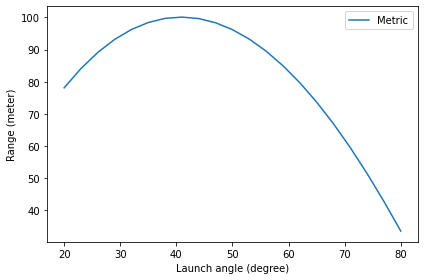

In [9]:
sweep.plot()

decorate(xlabel='Launch angle (degree)',
         ylabel='Range (meter)')

It looks like the range is maximized when the initial angle is near 40°.
We can find the optimal angle more precisely and more efficiently using `maximize_scalar`, like this:

In [10]:
res = maximize_scalar(range_func, params, bounds=[0, 90])

0 17.468795355645696
34.37694101250946 98.06996498016366
55.62305898749054 90.03182421721928
21.246117974981075 80.72039493627986
41.173855871044005 100.1200188931698
40.980120907838035 100.12368377099199
40.882137319070246 100.1241700443184
40.87925420124324 100.12417043309694
40.87928713865314 100.12417043314977
40.879291078324286 100.12417043314917
40.879283198981994 100.12417043314895


The first parameter is the function we want to maximize. The second is
the range of values we want to search; in this case, it's the range of
angles from 0° to 90°. 

The return value from `maximize_scalar` is an object that contains the
results, including `x`, which is the angle that yielded the maximum
range, and `fun`, which is the range when the ball is launched at the optimal angle.

In [11]:
res

     fun: 100.12417043314977
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 40.87928713865314

In [12]:
res.x, res.fun

(40.87928713865314, 100.12417043314977)

For these parameters, the optimal angle is about 41°, which yields a
range of 100 m.



## Summary

This chapter introduces the Manny Ramirez problem and starts to solve it.
As an exercise, you can finish it off.

If you enjoy this exercise, you might be interested in this paper: "How to hit home runs: Optimum baseball bat swing parameters for maximum range trajectories", by Sawicki, Hubbard, and Stronge, at
<http://modsimpy.com/runs>.

In the next chapter, we start a new topic: rotation!

## Exercise

**Exercise:** Let's finish off the Manny Ramirez problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial speed that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range; we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write an `event_func` that stops the simulation when the ball reaches the wall at `wall_distance`, which is a parameter in `params`.
Test your function with the initial conditions.

In [13]:
# Solution

def event_func(t, state, system):
    x, y, vx, vy = state
    return x - system.wall_distance

In [14]:
# Solution

system = make_system(params)
event_func(0, system.init, system)

-94.48799999999999

Next, write a function called `height_func` that takes a launch angle, simulates the flight of a baseball, and returns the height of the baseball when it reaches the wall.
Test your function with the initial conditions.

In [15]:
# Solution

def height_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)

    results, details = run_solve_ivp(system, slope_func, 
                                     events=event_func)
    height = results.iloc[-1].y
    return height

In [16]:
# Solution

height_func(40, params)

6.661045303535705

Now use `maximize_scalar` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [17]:
# Solution

res = maximize_scalar(height_func, params, bounds=[0, 90])
res

     fun: 7.217049532932801
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 43.105080979149434

In [18]:
# Solution

res.x, res.fun

(43.105080979149434, 7.217049532932801)

The angle that maximizes the height at the wall is a little higher than the angle that maximizes range.

Now, let's find the initial speed that makes the height at the wall exactly 37 feet, given that it's launched at the optimal angle. 
This is a root-finding problem, so we'll use `root_scalar`.

Write an error function that takes a speed and a `System` object as parameters.  It should use `maximize_scalar` to find the highest possible height of the ball at the wall, for the given speed.  Then it should return the difference between that optimal height and `wall_height`, which is a parameter in `params`.

In [19]:
# Solution

def error_func(speed, params):
    params = params.set(speed=speed)
    print(params.speed)
    res = maximize_scalar(height_func, params, bounds=[0, 90])
    return res.fun - params.wall_height

Test your error function before you call `root_scalar`.

In [20]:
# Solution

error_func(40, params)

40


-4.060550467067197

In [21]:
# Solution

error_func(50, params)

50


30.230189540329683

Then use `root_scalar` to find the answer to the problem, the minimum speed that gets the ball out of the park.

In [22]:
# Solution

bracket = [30, 50]
res = root_scalar(error_func, params, bracket=bracket)

30
30.0
50.0
42.95327159575888
41.030931458411445
41.039294634028856
41.037242669296155


In [23]:
# Solution

res

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 41.039294634028856

In [24]:
# Solution

min_speed = res.root
min_speed

41.039294634028856

And just to check, run `error_func` with the value you found.

In [25]:
# Solution

error_func(min_speed, params)

41.039294634028856


0.0010039392295357885

## Under the Hood

`maximize_scalar` uses a SciPy function called `minimize_scalar`, which provides several optimization methods.  By default, it uses `bounded`, a version of Brent's algorithm that is safe in the sense that it always uses values within the bounds you provide (including both ends).
You can read more about it at <http://modsimpy.com/minimize>).